In [1]:
#install tensorflow 
#activate venv-metal virtual environment. Then open jupyter notebook
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# Import data into tensorflow dataset object

In [2]:
IMAGE_SIZE= 256 #Image size can be found in the image-right click Properties part.
BATCH_SIZE=32 #standard 

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.
Metal device set to: Apple M1


2023-02-24 13:31:16.393143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 13:31:16.393768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
len(dataset) #68 means there are 68 batches 

68

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    
#There are three labels:0,1,2 -- early bright, late bright, healthy
#3: RGB
#32: batch suize 

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


2023-02-24 13:31:20.031339: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


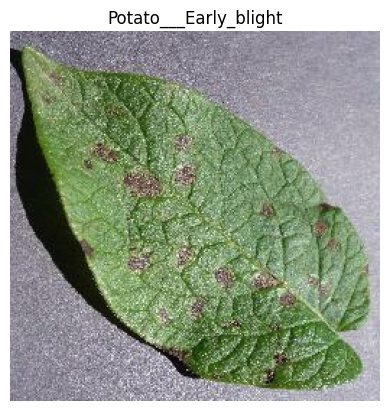

In [7]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")

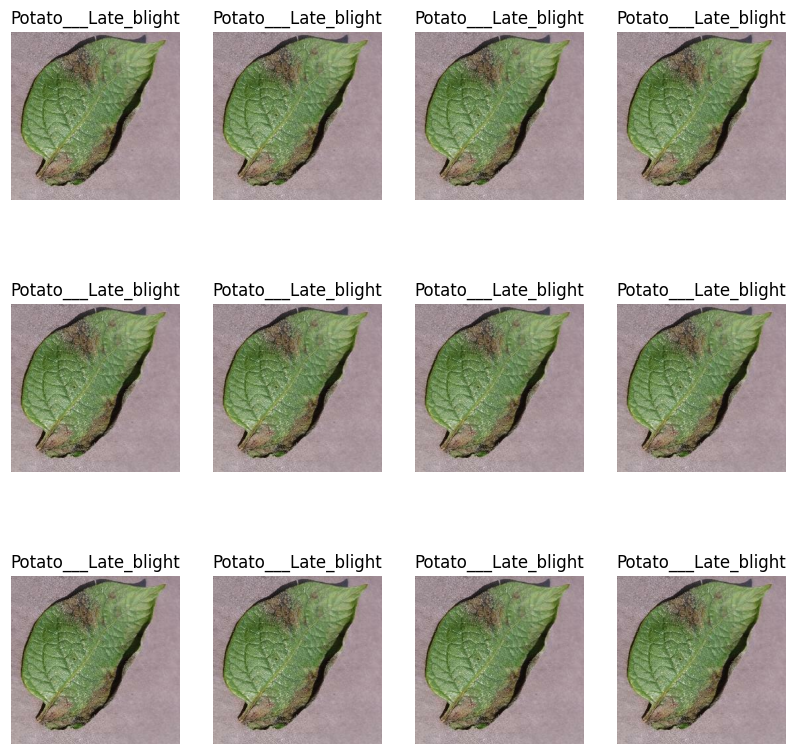

In [8]:
plt.figure(figsize= (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[0]])
        plt.axis("off")

In [16]:
len(dataset)
#actual size 68*32

68

# Split the dataset: 80% training, 10% validation, 10% test sets 

1. Training set- Manually

In [12]:
# Training data 
train_size=0.8 
len(dataset)*train_size

54.400000000000006

In [13]:
training_df= dataset.take(54) #take first 54 samples as training 
len(training_df)

54

2. Validation and Test sets- Manually

In [14]:
test_and_validation_ds= dataset.skip(54) #you 
len(test_and_validation_ds)

14

In [15]:
#Validation set
val_size=0.1
len(dataset)*val_size # 10 percent of the total dataset is ~6. 

6.800000000000001

In [16]:
val_ds = test_and_validation_ds.take(6) #so we will take 6 samples from the remainin samples after training samples
len(val_ds)

6

In [17]:
# Test set 
test_ds = test_and_validation_ds.skip(6) #exclude top 6 (validation), the rest is the test set 
len(test_ds)

8

# Create a function for partitioning dataset to training, test,validation 

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size=10000):
    ds_size= len(ds) 
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int (ds_size*train_split)
    val_size= int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds= ds.skip(train_size).take(val_size)
    test_ds=  ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [19]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf (dataset)

In [20]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


# Cache, Shuffle, and Prefetch the Dataset

In [21]:
# Make the model faster
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
resize_and_rescale= tf.keras.Sequential([
   layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
   layers.experimental.preprocessing.Rescaling(1.0/255),
])


In [23]:
#data augmentation
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Create the model 

In [28]:
#layers.Conv2d (filter, filter_size)
n_classes=3 
CHANNELS=3
input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape), 
    layers.MaxPooling2D((2,2)),           
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),    
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),            
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),           
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

# Model compile

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10


2023-02-24 13:32:54.250512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 1.6613 - accuracy: 0.4705

2023-02-24 13:33:06.529688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 14s 224ms/step - loss: 1.6613 - accuracy: 0.4705 - val_loss: 0.8619 - val_accuracy: 0.6198
Epoch 2/10
54/54 [==============================] - 11s 211ms/step - loss: 0.7416 - accuracy: 0.6464 - val_loss: 0.5068 - val_accuracy: 0.8698
Epoch 3/10
54/54 [==============================] - 11s 199ms/step - loss: 0.4301 - accuracy: 0.8125 - val_loss: 0.2138 - val_accuracy: 0.9271
Epoch 4/10
54/54 [==============================] - 11s 199ms/step - loss: 0.1986 - accuracy: 0.9184 - val_loss: 0.0779 - val_accuracy: 0.9844
Epoch 5/10
54/54 [==============================] - 11s 200ms/step - loss: 0.2088 - accuracy: 0.9213 - val_loss: 0.1974 - val_accuracy: 0.9062
Epoch 6/10
54/54 [==============================] - 11s 199ms/step - loss: 0.1453 - accuracy: 0.9427 - val_loss: 0.1212 - val_accuracy: 0.9479
Epoch 7/10
54/54 [==============================] - 11s 199ms/step - loss: 0.0852 - accuracy: 0.9635 - val_loss: 0.0484 - val_accuracy: 0.9896
Epoch 8/10

# Evaluate model 

In [33]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 69ms/step - loss: 0.1274 - accuracy: 0.9609


[0.12744072079658508, 0.9609375]

# Score parameters

In [34]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 1s 69ms/step - loss: 0.1274 - accuracy: 0.9609


[0.12744072079658508, 0.9609375]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
history.history['accuracy'] #all accuracy values in the model fitting 

[0.4704861044883728,
 0.6464120149612427,
 0.8125,
 0.9184027910232544,
 0.9212962985038757,
 0.9427083134651184,
 0.9635416865348816,
 0.9646990895271301,
 0.9137731790542603,
 0.9369212985038757]

In [40]:
# All values we see in the model fitting. We will use them for plotting
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss ')

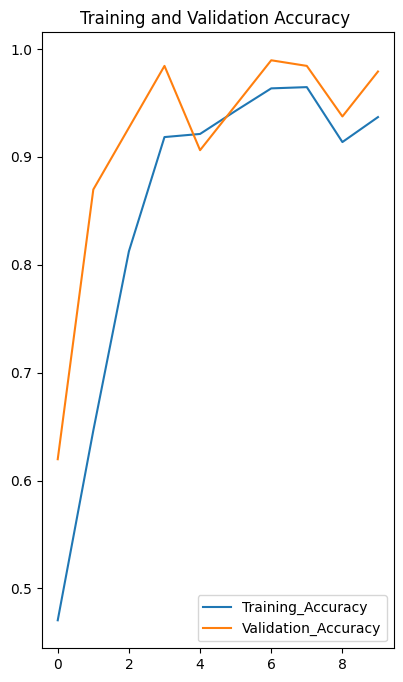

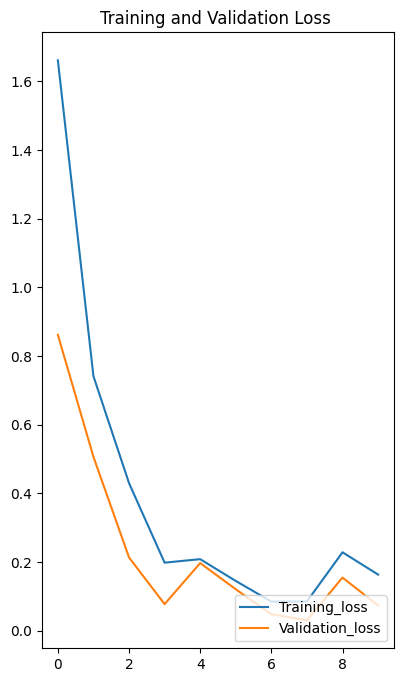

In [48]:
EPOCHS=10
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training_Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation_Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy ')

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training_loss')
plt.plot(range(EPOCHS),val_loss,label='Validation_loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss ')

# Model prediction on sample images 

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 20ms/step
predicted label: Potato___Late_blight


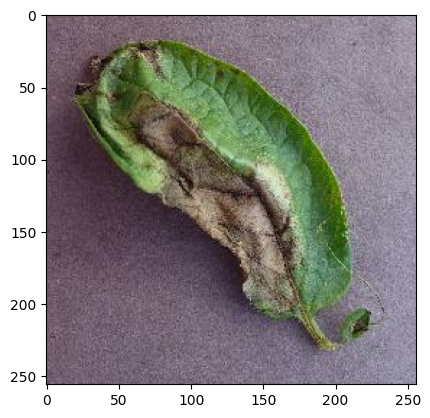

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Create a function for model prediction and confidence

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 10ms/step


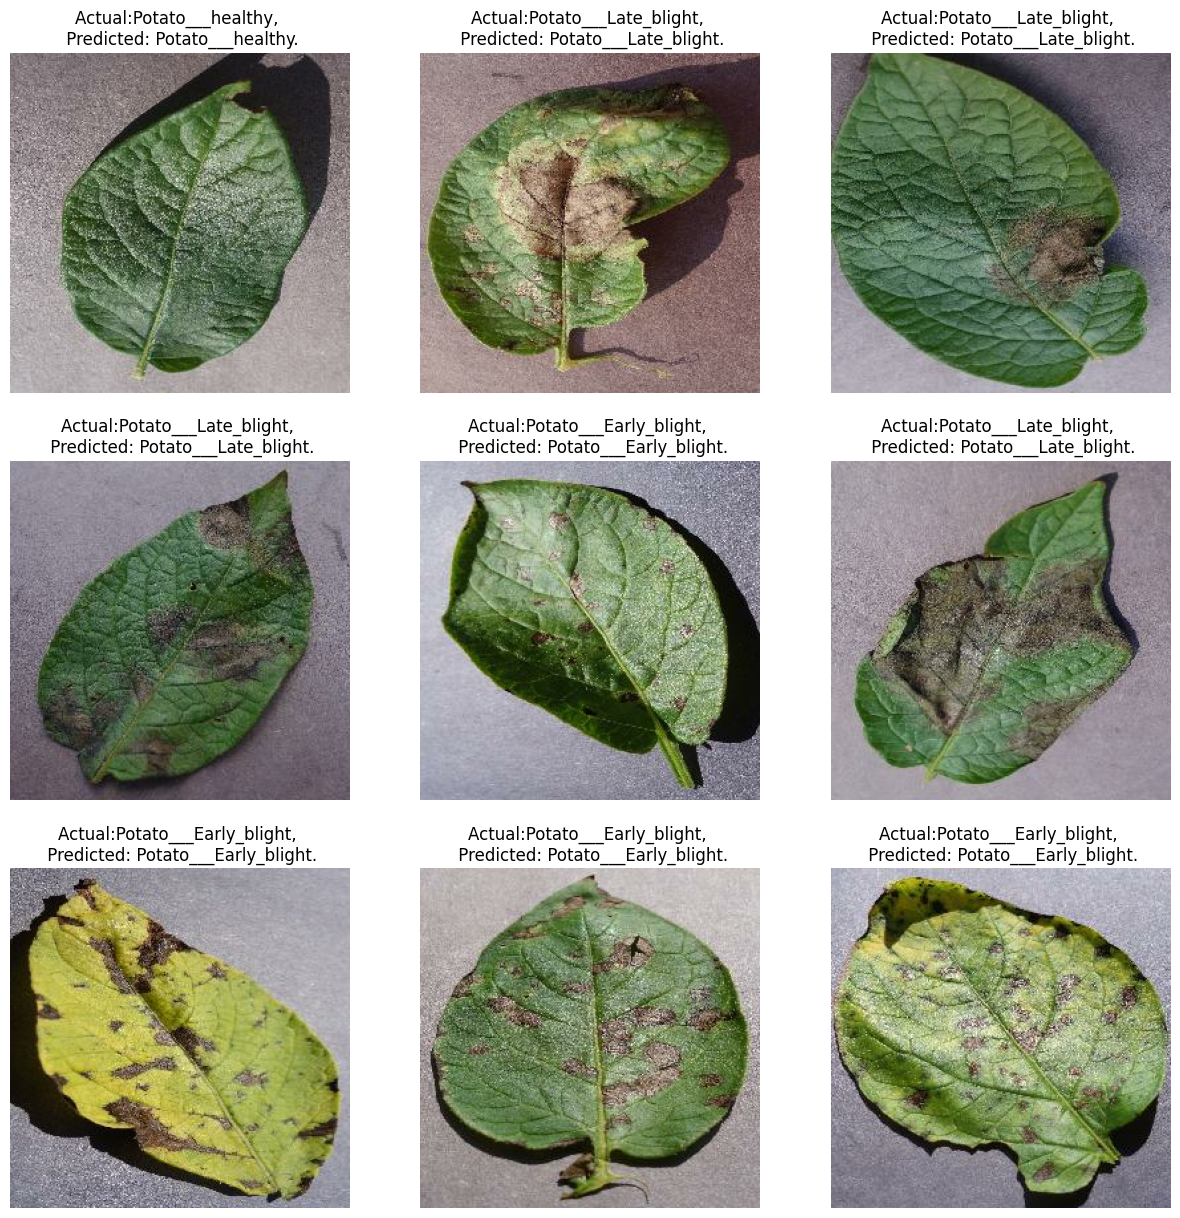

In [65]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")
        
       

In [71]:
model_version= 1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets
